# Cuda DTW Tests
*   Author: A. T. Hannington
*   Email: HanningtonAT@cardiff.ac.uk
*   Date Last Updated: 25/09/2020



In [1]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')   #For suppressing plotting on clusters
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform, euclidean, cityblock
from fastdtw import fastdtw
from itertools import combinations
import time
import torch
import torch.nn as nn
print(torch.__version__)

1.6.0+cu101


## Import Soft-DTW-Cuda

In [2]:
!git clone https://github.com/Maghoumi/pytorch-softdtw-cuda.git

Cloning into 'pytorch-softdtw-cuda'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 5), reused 11 (delta 4), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [3]:
!cp pytorch-softdtw-cuda/soft_dtw_cuda.py .

In [4]:
from soft_dtw_cuda import SoftDTW

## Set PyTorch device to GPU ("cuda")

In [7]:
cuda = torch.device('cuda')

## Constants and control parameters

In [66]:
pi = 3.141596


n_n = 20 #Number of time series
n_t = 500 #Number of data points on temporal axis 
n_q = 2   #Number of dimensions of data (number of different physical quantities)
min_n_n = 10 #min and max number of time series for scaling tests
max_n_n = 300
increment_n_n = 10 #Increment to change n_n in scaling tests
batch_limit = 45 #DO NOT CHANGE --- Controls batch size of number of time series passed to GPU. Empirical value of 45 for 1 GPU 
percent_cluster_distance = 84. #Distance from bottom of dendogram to cut by

delta_t = 1 #Size of time step

## Define Functions

In [9]:
def sin_func(x,l,a):
    """
    Sin function data generator. Amplitude a, wavelength l
    """
    y = [a*np.sin(2*pi*val/l) for val in x]
    return y

In [10]:
def lin_func(x,m,c):
  """
  Linear function data generator. Gradient m, intercept c
  """
  y = [m*val + c for val in x]
  return y

In [11]:
def DTW_prep(M):
    """
    Function to obtain unique combinations of time series.
    Will return time series index in Matrix m (0,1,2....) and unique partner (0,1,2...) ignoring (1,2)==(2,1) etc
    Returns pairs as list of tuples
    """
    elements = range(np.shape(M)[0])
    iterator = combinations(elements,r=2)
    
    pairs = []
    for pair in iterator:
      pairs.append(pair)

    return pairs

In [12]:
def DTW_select(M,selected_pairs):
  """
  Split the Time Series in M into Matrices M1 M2 according to pairs
  such that (1,2) -> M1[0] = M[1], M2[0] = M[2] etc.
  Also send M1 and M2 to cuda device, and reshape as (Len(pairs),n_t,1)
  which translates to (number of time series to be compared, number of temporal data points, number of dimensions of data [untested])
  """
  M1_list = []
  M2_list = []
  for pair in selected_pairs:
    M1_list.append(M[pair[0]])
    M2_list.append(M[pair[1]])

  M1 = torch.tensor(M1_list, device=cuda).view(len(M1_list),np.shape(M)[1],1)
  M2 = torch.tensor(M2_list, device=cuda).view(len(M2_list),np.shape(M)[1],1)
  return M1, M2 

In [13]:
x_data_n_n = []
y_data_t = []

## Set up Synthetic Data

In [203]:
n_t= int(n_t * delta_t)
n_n_tmp = int((n_n/2))

print(f"n_t = {n_t}")
print(f"n_n_tmp = {n_n_tmp}")

x_dat = [i for i in np.arange(0,n_t,delta_t)]

sin_dat = np.array([sin_func(x_dat,float(n_t)/float(l),n_t) for l in np.arange(1,n_n_tmp+1,1)])
print("Done sin_dat!")
lin_dat = np.array([lin_func(x_dat,m,0.) for m in np.arange(1,n_n_tmp+1,1)])
print("Done lin_dat!")

# sin_dat_normed = []
# for tseries in sin_dat:
#   maxVal = np.max(tseries)
#   sin_dat_normed.append(tseries/maxVal)
# sin_dat_normed = np.array(sin_dat_normed)

# lin_func_normed = []
# maxVal = np.max(lin_dat)
# for tseries in lin_dat:
#   lin_func_normed.append(tseries/maxVal)
# lin_func_normed = np.array(lin_func_normed)

print(f"np.shape(sin_dat) = {np.shape(sin_dat)}")
print(f"np.shape(lin_dat) = {np.shape(lin_dat)}")
# Mtmp = np.concatenate((sin_dat,lin_dat),axis=0).reshape(n_n,n_t)
# Mtmp2 = np.concatenate((Mtmp,sin_dat+lin_dat),axis=0)
# M = np.concatenate((Mtmp2,sin_dat-lin_dat),axis=0)
M = sin_dat
print(f"np.shape(M) = {np.shape(M)}")
del sin_dat, lin_dat

n_t = 500
n_n_tmp = 10
Done sin_dat!
Done lin_dat!
np.shape(sin_dat) = (10, 500)
np.shape(lin_dat) = (10, 500)
np.shape(M) = (10, 500)


## Prepare for DTW

Adjust for multiple CPUs

In [149]:
n_gpus = torch.cuda.device_count()
print(f"Running on {n_gpus} GPUs")
multi_batch_limit = n_gpus * batch_limit

Running on 1 GPUs


Adjust Batch limit to ensure last batch > 1 so there are no time series missed out by DTW

In [204]:
pairs = DTW_prep(M)
n_pairs = len(pairs)
while True:
  last_batch_size = n_pairs%multi_batch_limit
  if last_batch_size > 1:
    break
  else:
    multi_batch_limit -= 1

print("last_batch_size",last_batch_size)
print("multi_batch_limit",multi_batch_limit)

last_batch_size 2
multi_batch_limit 43


Perform DTW, with data split into batches by PyTorch DataLoader

In [205]:
M1, M2 = DTW_select(M,pairs)
x_loader = torch.utils.data.DataLoader(M1,batch_size=multi_batch_limit)
y_loader = torch.utils.data.DataLoader(M2,batch_size=multi_batch_limit)
dtw = nn.DataParallel(SoftDTW(use_cuda=True,gamma=1e-10,normalize=True))


out = torch.empty((0), dtype=torch.float64, device=cuda)

start = time.time()
for (x,y) in zip(x_loader,y_loader):
  out_tmp = dtw.forward(x,y)
  out = torch.cat((out,out_tmp),dim=0)

end = time.time()
elapsed = end - start
print(f"Elapsed time in DTW = {elapsed}s")

Elapsed time in DTW = 0.12120771408081055s


Get Similarity Matrix D, back in CPU form and as numpy array.
Normalize to range(0,1)

In [206]:
D = squareform(out.cpu().detach().numpy())
D = D/np.max(D)

## Scaling Tests

In [ ]:
# for n_n in np.arange(start= min_n_n, stop= max_n_n + increment_n_n, step= increment_n_n, dtype= np.int32):


#     n_t= int(n_t * delta_t)
#     n_n_tmp = int((n_n/2))

#     print(f"n_t = {n_t}")
#     print(f"n_n = {n_n}")

#     x = [i for i in np.arange(0,n_t,delta_t)]

#     sin_dat = np.array([sin_func(x,float(n_t)/float(l),n_t) for l in np.arange(1,n_n_tmp+1,1)])
#     # print("Done sin_dat!")
#     lin_dat = np.array([lin_func(x,m,0.) for m in np.arange(1,n_n_tmp+1,1)])
#     # print("Done lin_dat!")

#     # print(f"np.shape(sin_dat) = {np.shape(sin_dat)}")
#     # print(f"np.shape(lin_dat) = {np.shape(lin_dat)}")
#     M = np.concatenate((sin_dat,lin_dat),axis=0)
#     # print(f"np.shape(M) = {np.shape(M)}")
#     del sin_dat, lin_dat
#     print("Synthetic Data (M Matrix) Generated!")
#     pairs = DTW_prep(M)
#     n_pairs = len(pairs)
#     while True:
#       last_batch_size = n_pairs%batch_limit
#       if last_batch_size > 1:
#         break
#       else:
#         batch_limit -= 1

#     M1, M2 = DTW_select(M,pairs)
#     x_loader = torch.utils.data.DataLoader(M1,batch_size=multi_batch_limit)
#     y_loader = torch.utils.data.DataLoader(M2,batch_size=multi_batch_limit)
#     dtw = nn.DataParallel(SoftDTW(use_cuda=True,gamma=1e-5,normalize=True))


#     out = torch.empty((0), dtype=torch.float64, device=cuda)
#     completed=0.
#     print("Starting DTW!")
#     start = time.time()
#     for (x,y) in zip(x_loader,y_loader):
#       out_tmp = dtw.forward(x,y)
#       out = torch.cat((out,out_tmp),dim=0)

#     end = time.time()
#     elapsed = end - start
#     print(f"Elapsed time in DTW = {elapsed}s")
#     # print(out.size())

#     x_data_n_n.append(n_n)
#     y_data_t.append(elapsed)

#     percent = (float(n_n)/float(max_n_n))*100.
#     print(f"{percent:0.01f}%")
#     print("")

In [ ]:
# y_lin = [x for x in x_data_n_n]
# y_quad = [x**2 for x in x_data_n_n]
# y_xlogx = [x * np.log(x) for x in x_data_n_n]

# coeffs = np.polyfit(x_data_n_n,y_data_t,deg=2)
# fit = np.poly1d(coeffs)

In [ ]:
# plt.figure(figsize=(8,8))
# plt.plot(x_data_n_n,y_data_t, label="Results", color="black")
# plt.plot(x_data_n_n,y_quad, label="Quadratic Fit O(N^2)", color = "green")
# plt.plot(x_data_n_n,y_quad, label="N Log N Fit O(N Log(N))", color = "orange")
# plt.plot(x_data_n_n,y_lin, label="Linear Fit O(N)", color="blue")
# plt.plot(x_data_n_n,fit(x_data_n_n), label=f"Polynomial Fit {coeffs[0]:0.04f}x^2 + {coeffs[1]:0.04f}x + {coeffs[2]:0.04f}", color="red", linestyle="-.")
# plt.ylim(np.min(y_data_t), np.max(y_data_t))
# plt.legend()
# plt.xlabel("N Time Series")
# plt.ylabel("Run Time [s]")
# plt.title("DTW Scaling test - SoftDTW-Cuda Package" + f" - {n_gpus} GPUs" + f" - {n_t} Temporal Data Points" + "\n" + " Reduced Matrix + DataLLoader + Batch + GPU Tensor Method")

# # plt.show()
# plt.savefig(f"DTW_time_scaling_test.png")
# plt.close()

## Heirarchical Clustering using SKLearn

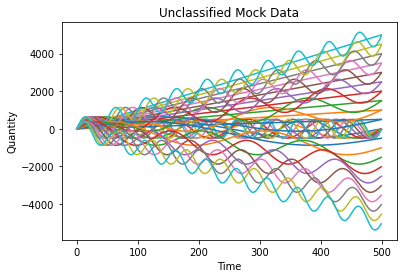

In [158]:
all_plot = plt.figure()
for tseries in M:
  plt.plot(x_dat,tseries)
  plt.xlabel("Time")
  plt.ylabel("Quantity")
  plt.title("Unclassified Mock Data")

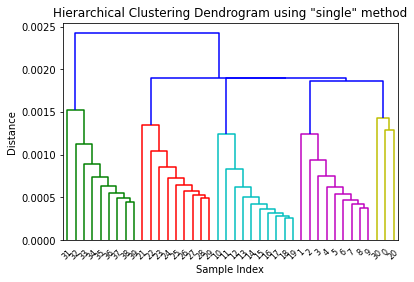

In [159]:
method = 'single'
Z= linkage(squareform(D),method=method)
dendo_plot = plt.figure()
plt.title(f'Hierarchical Clustering Dendrogram using "{method}" method')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
ddata = dendrogram(Z)
plt.show()

Find distance to cut dendogram at by finding biggest difference between levels and cutting at halfway up that distance

In [200]:
sort_level = 1
maxmimally_distinct_bool = True

In [201]:
distance_levels = np.array(abs(Z[:-1,2] - Z[1:,2]))

if (maxmimally_distinct_bool == True) :
  sorted_distance_levels_index = np.argsort(distance_levels)

  level = -1 - sort_level

  biggest_diff_loc = sorted_distance_levels_index[level]

  d_crit = Z[biggest_diff_loc,2] + (0.25  * distance_levels[biggest_diff_loc])
else:
  level = -1 - sort_level
  d_crit = Z[level,2] - 0.25*(Z[level+1,2])

print(f"d_crit = {d_crit:0.05f}")

d_crit = 0.00161


Generate clusters, and assign first to Clusters' time series to new variables

In [139]:
clusters = fcluster(Z, t=d_crit, criterion='distance')
cluster1 = M[np.where(clusters==1)]
cluster2 = M[np.where(clusters==2)]
cluster3 = M[np.where(clusters==3)]
cluster4 = M[np.where(clusters==4)]

In [ ]:
cluster1 = M[np.where(cl.labels_==0)]
cluster2 = M[np.where(cl.labels_==1)]

Test that recovered clusters make sense from synthetic data

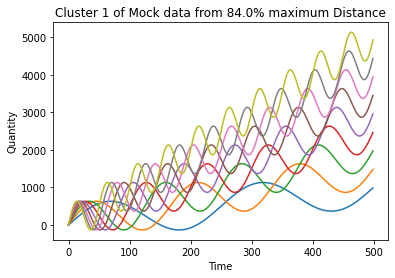

In [136]:
cluster1_fig = plt.figure()
for tseries in cluster1:
  plt.plot(x_dat,tseries)
  plt.xlabel("Time")
  plt.ylabel("Quantity")
  plt.title(f"Cluster 1 of Mock data from Maximally Ditinct Classifier")

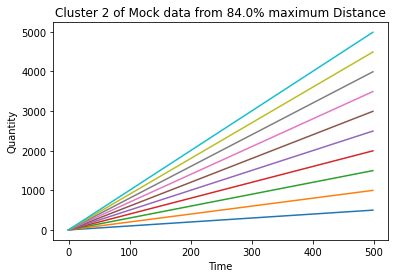

In [137]:
cluster2_fig = plt.figure()
for tseries in cluster2:
  plt.plot(x_dat,tseries)
  plt.xlabel("Time")
  plt.ylabel("Quantity")
  plt.title(f"Cluster 2 of Mock data from {percent_cluster_distance}% maximum Distance")

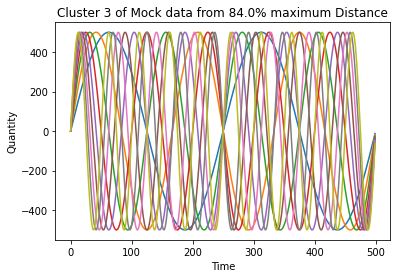

In [140]:
cluster3_fig = plt.figure()
for tseries in cluster3:
  plt.plot(x_dat,tseries)
  plt.xlabel("Time")
  plt.ylabel("Quantity")
  plt.title(f"Cluster 3 of Mock data from {percent_cluster_distance}% maximum Distance")

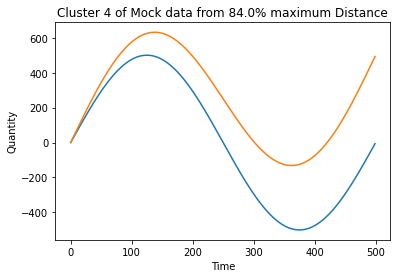

In [141]:
cluster4_fig = plt.figure()
for tseries in cluster4:
  plt.plot(x_dat,tseries)
  plt.xlabel("Time")
  plt.ylabel("Quantity")
  plt.title(f"Cluster 4 of Mock data from {percent_cluster_distance}% maximum Distance")

## Make ~fancy~ plot

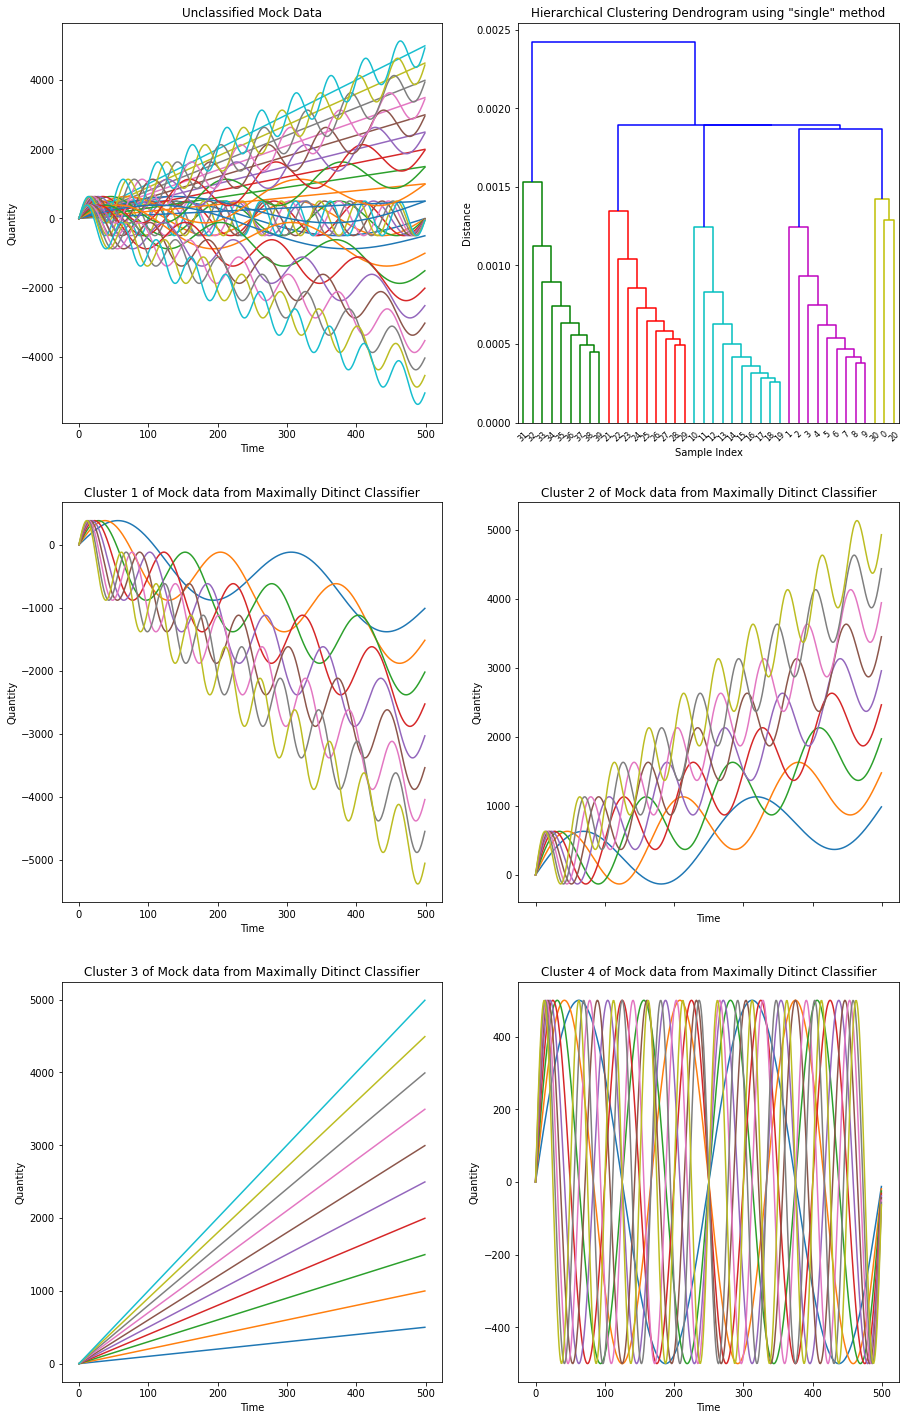

In [202]:
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(15,25))

for tseries in M:
  ax[0,0].plot(x_dat,tseries)
  ax[0,0].set_xlabel("Time")
  ax[0,0].set_ylabel("Quantity")
  ax[0,0].set_title("Unclassified Mock Data")

method = 'single'
Z= linkage(squareform(D),method=method)

ddata = dendrogram(Z,ax=ax[0,1])
ax[0,1].set_title(f'Hierarchical Clustering Dendrogram using "{method}" method')
ax[0,1].set_xlabel('Sample Index')
ax[0,1].set_ylabel('Distance')

clusters = fcluster(Z, t=d_crit, criterion='distance')
cluster1 = M[np.where(clusters==1)]
cluster2 = M[np.where(clusters==2)]
cluster3 = M[np.where(clusters==3)]
cluster4 = M[np.where(clusters==4)]

for tseries in cluster1:
  ax[1,0].plot(x_dat,tseries)
  ax[1,0].set_xlabel("Time")
  ax[1,0].set_ylabel("Quantity")
  ax[1,0].set_title(f"Cluster 1 of Mock data from Maximally Ditinct Classifier")

for tseries in cluster2:
  ax[1,1].plot(x_dat,tseries)
  ax[1,1].set_xlabel("Time")
  ax[1,1].set_ylabel("Quantity")
  ax[1,1].set_title(f"Cluster 2 of Mock data from Maximally Ditinct Classifier")

for tseries in cluster3:
  ax[2,0].plot(x_dat,tseries)
  ax[2,0].set_xlabel("Time")
  ax[2,0].set_ylabel("Quantity")
  ax[2,0].set_title(f"Cluster 3 of Mock data from Maximally Ditinct Classifier")

for tseries in cluster4:
  ax[2,1].plot(x_dat,tseries)
  ax[2,1].set_xlabel("Time")
  ax[2,1].set_ylabel("Quantity")
  ax[2,1].set_title(f"Cluster 4 of Mock data from Maximally Ditinct Classifier")

labels = [item.get_text() for item in ax[1,1].get_xticklabels()]
labels[1] = ''

ax[1,1].set_xticklabels(labels)

plt.savefig(f"n_n-{n_n}_n_t-{n_t}_DTW_classifier.pdf")
plt.show()

In [213]:
clusters

array([5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)